In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 1,
 'M_max': 10000000000.0,
 'fwimp': 1.0,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 10000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 60000,
 'psh_log_f_min': -5.7,
 'psh_log_f_max': -3,
 'N_psh': 500,
 'omega_pixel': 6.391586616190171e-05}

In [4]:
with np.load('./output/n0_pshfunc.npz') as f:
    psi = f['psi']
    fluxes = f['flux']
    psh2d = f['psh']

In [5]:
pshfunc2d = intp.interp2d(psi, fluxes, psh2d, bounds_error=False, fill_value=0)
fluxes = fluxes[0:-1]
np.log10(fluxes[-1])

-3.010843373493976

2.327035771528025e-05
1.9730193106608333e-05
1.6877938408392237e-05
1.4602068757663993e-05
1.2811731294466706e-05
1.144641755940512e-05
1.0297673178372798e-05
9.337009569702939e-06
8.560318601682113e-06
7.934055821577645e-06
7.4004523786606505e-06
6.949713721103001e-06
6.5906359404929405e-06
6.299897837014986e-06
5.645389507424078e-06
4.560888600996368e-06
4.514895073545145e-06
4.3974742610948e-06
4.321636825747141e-06
4.372077114383677e-06


[Text(1, 0, '40.0'),
 Text(1, 0, '50.0'),
 Text(1, 0, '60.0'),
 Text(1, 0, '70.0'),
 Text(1, 0, '80.0'),
 Text(1, 0, '90.0'),
 Text(1, 0, '100.0'),
 Text(1, 0, '110.0'),
 Text(1, 0, '120.0'),
 Text(1, 0, '130.0'),
 Text(1, 0, '140.0'),
 Text(1, 0, '150.0'),
 Text(1, 0, '160.0'),
 Text(1, 0, '170.0'),
 Text(1, 0, '180.0')]

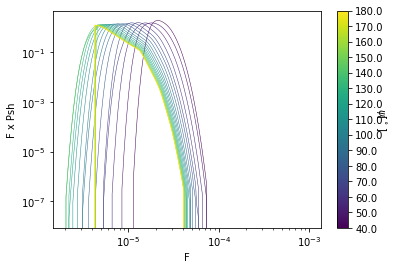

In [6]:
numnum = 20
psis = np.linspace(40, 180, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []
fxs = fluxes
for psi, col in zip(psis, colors):
    ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$", color=col, lw=0.5)
    print(np.trapz(fxs * pshfunc2d(psi, fxs).flatten(), fxs))
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [7]:
counts = np.arange(0, 20)
exposure = 1 * 14000 * 0.2/0.5
psi = 40

In [8]:
from scipy.stats import poisson
print(poisson.pmf(counts[:, np.newaxis], exposure * fluxes).shape, pshfunc2d(40, fluxes).flatten().shape)

pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
# func = pshfunc2d(40, fluxes).flatten() * poisson.pmf(2, exposure * fluxes)
pcvals

(20, 249) (249,)


array([8.78295074e-01, 1.13777462e-01, 7.69511162e-03, 3.63365087e-04,
       1.35096460e-05, 4.22556308e-07, 1.15926740e-08, 2.86961241e-10,
       6.53895510e-12, 1.39186657e-13, 2.79798791e-15, 5.35649587e-17,
       9.82922366e-19, 1.73772003e-20, 2.97185239e-22, 4.93253940e-24,
       7.96583254e-26, 1.25426976e-27, 1.92853816e-29, 2.89898945e-31])

In [9]:
print(exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))
pp = poisson.pmf(counts, exposure*np.trapz(fluxes * pshfunc2d(40, fluxes).flatten(), fluxes))

0.1303140032055694


Text(0, 0.5, 'P(C) for 40 deg, n=0')

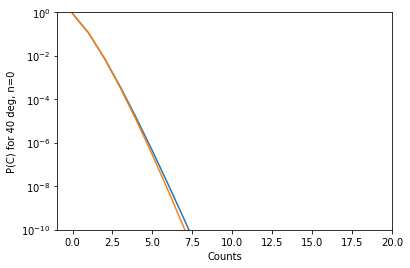

In [10]:
plt.plot(counts, pcvals)
plt.plot(counts, pp)
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(top=1, bottom=1e-10)
ax.set_xlim(right=20)
ax.set_xlabel('Counts')
ax.set_ylabel('P(C) for 40 deg, n=0')

In [11]:
import healpy

In [12]:
nside = p['nside']
npix = healpy.nside2npix(nside)
pixel_counts = np.ones(npix) * healpy.pixelfunc.UNSEEN
print(npix)

196608


In [13]:
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
ang_dists, lon, lat

(array([89.74156502, 90.25843498, 90.25843498, ..., 90.25843498,
        90.25843498, 89.74156502]),
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]))

In [14]:
lon, lat, max(ang_dists), min(ang_dists)

(array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.6345165,  89.6345165,  89.6345165, ..., -89.6345165,
        -89.6345165, -89.6345165]),
 179.70158313251247,
 0.2984168674875423)

In [15]:
psis = np.linspace(40, 180, num=50)
pc_psi = np.array([np.trapz(pshfunc2d(abs(psi), fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1) for psi in psis])
pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)

In [16]:
good_indices = (abs(lat) >= 40)
subsample = ang_dists[good_indices]
print(len(subsample))
sub_counts = np.zeros(len(subsample))
for i, psi in enumerate(subsample):
    if i % 100000 == 0:
        print(i, '/', len(subsample))
#     print(psi)
    pcvals = pc_of_psi(abs(psi))
    sub_counts[i] = np.random.choice(np.arange(len(pcvals)), size=1, p=pcvals/np.sum(pcvals))
    
pixel_counts[good_indices] = sub_counts
pixel_counts_pc = pixel_counts[:]

70144
0 / 70144


In [17]:
np.sum(pixel_counts > 0)

4039

0.8392936452111668


(0.05970574817518248, 4188.0)

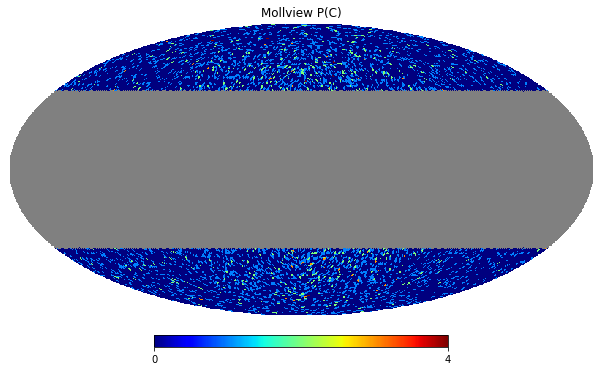

In [18]:
nreduce = 64
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_pc), nreduce, pess=True, power=-2), cmap=cm.jet, title="Mollview P(C)")
print(healpy.nside2pixarea(nreduce, degrees=True))
np.mean(pixel_counts_pc[good_indices]), np.sum(pixel_counts_pc[good_indices])

In [19]:
lsub = len(subsample)
pixel_counts_poisson = np.ones(npix) * healpy.pixelfunc.UNSEEN
sub_counts = np.zeros(lsub)
for i, psi in enumerate(subsample):
    if i % 100000 == 0:
        print(i, '/', lsub)
#     print(psi)
    sub_counts[i] = stats.poisson.rvs(exposure*np.trapz(fluxes * pshfunc2d(psi, fluxes).flatten(), fluxes))
    if sub_counts[i] > 5: 
        print(sub_counts[i])
    
pixel_counts_poisson[good_indices] = sub_counts


0 / 70144


(0.05867928832116788, 4116.0)

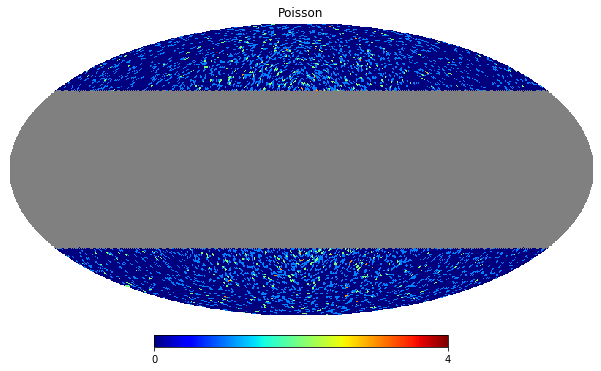

In [20]:
healpy.mollview(healpy.pixelfunc.ud_grade(healpy.pixelfunc.ma(pixel_counts_poisson), nreduce, pess=True, power=-2), cmap=cm.jet, title="Poisson")
np.mean(pixel_counts_poisson[good_indices]), np.sum(pixel_counts_poisson[good_indices])

In [21]:
import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self, x):
        return custom_pdf(x)
    
    def _cdf(self, x):
        return custom_cdf(x)
    
    def _ppf(self, x):
        return custom_ppf(x)

In [22]:
psi = 50
custom_pdf = lambda x: pshfunc2d(psi, x).flatten()

norm = np.trapz(pshfunc2d(psi, fluxes).flatten(), fluxes)
discrete_cdf = integrate.cumtrapz(pshfunc2d(psi, fluxes).flatten(), fluxes, initial=0)
custom_cdf = intp.interp1d(fluxes, discrete_cdf, fill_value=0, bounds_error=False)

custom_ppf = intp.interp1d(discrete_cdf, fluxes, fill_value=0, bounds_error=False)

func50 = my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [23]:
# pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)

def pc(psi, counts_max=15):
    counts = np.arange(0, counts_max + 1)
    
    pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
    custom_pdf = intp.interp1d(counts, pcvals, fill_value=0, bounds_error=False)
    
    discrete_cdf = integrate.cumtrapz(pcvals, counts, initial=0)
    custom_cdf = intp.interp1d(counts, discrete_cdf, fill_value=0, bounds_error=False)

    custom_ppf = intp.interp1d(discrete_cdf, counts, fill_value=0, bounds_error=False)
    
    return my_pdf(a=fluxes.min(), b=fluxes.max(), name='my_pdf')

In [24]:
pc(50).rvs(size=10)

array([2.22352956e-05, 2.30602834e-05, 1.64515881e-05, 1.52690525e-05,
       2.30073061e-05, 1.44730079e-05, 1.52548486e-05, 1.72079769e-05,
       2.05051173e-05, 2.57000293e-05])

1.0


Text(0, 0.5, 'P(C) for 40 deg, n=0')

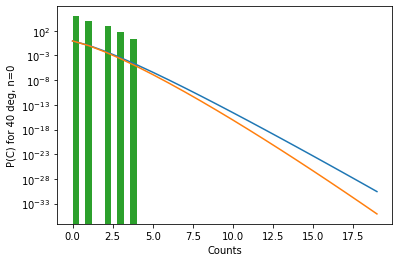

In [25]:
psi = 40
pcvals = np.trapz(pshfunc2d(psi, fluxes).flatten() * poisson.pmf(counts[:, np.newaxis], exposure * fluxes), fluxes, axis=-1)
pp = poisson.pmf(counts, exposure*fluxes[np.argmax(pshfunc2d(psi, fluxes))])

print(np.sum(pcvals/np.sum(pcvals)))
plt.plot(counts, pcvals)
plt.plot(counts, pp)
plt.hist(np.random.choice(np.arange(len(pcvals)), size=100000, p=pcvals/np.sum(pcvals)))

ax = plt.gca()
ax.set_yscale('log')
# ax.set_ylim(top=1, bottom=1e-20)
ax.set_xlabel('Counts')
# ax.set_xscale('log')
ax.set_ylabel('P(C) for 40 deg, n=0')

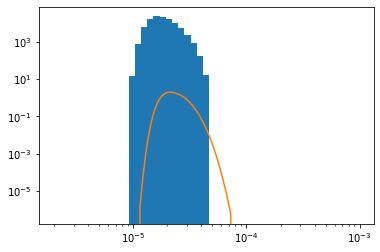

In [26]:
fig, ax = plt.subplots()
bins = np.logspace(np.log10(fluxes.min()), np.log10(fluxes.max()), num=50)
ax.hist(func50.rvs(size=100000), bins=bins)
ax.plot(fxs, fxs * pshfunc2d(psi, fxs).flatten(), label=rf"{psi}$^\circ$")
ax.set_xscale('log')
ax.set_yscale('log')

In [27]:
for i, latt in enumerate(lat):
    if latt < 40:
        pixel_counts[i] = 0
    else:
        

SyntaxError: unexpected EOF while parsing (<ipython-input-27-3e4a41aa4645>, line 5)